In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

## 数据集加载

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

170500096it [01:20, 2107066.11it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## 数据可视化

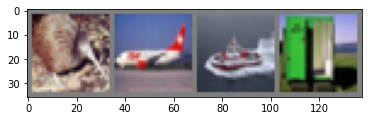

 bird plane  ship truck


In [24]:
import matplotlib.pyplot as plt
import numpy as np
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 定义一个简单网络

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Net()

## 设定损失函数和优化器

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


## 训练网络

In [14]:
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training')

[1,  2000] loss: 1.245
[1,  4000] loss: 1.281
[1,  6000] loss: 1.252
[1,  8000] loss: 1.264
[1, 10000] loss: 1.252
[1, 12000] loss: 1.244
[2,  2000] loss: 1.258
[2,  4000] loss: 1.253
[2,  6000] loss: 1.263
[2,  8000] loss: 1.270
[2, 10000] loss: 1.244
[2, 12000] loss: 1.253
Finished Training


## 保存网络

In [15]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## 加载网络

In [16]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 测试模型

In [31]:
dataiter = iter(testloader)
images, labels = dataiter.next()
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))


Predicted:    cat  ship  ship  ship


In [22]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 52 %


In [21]:
import coremltools

example_input = torch.rand(1, 3, 32, 32) 

net.eval()

# Trace the model with random data.
traced_net = torch.jit.trace(net, example_input)
out = traced_net(example_input)

model = coremltools.convert(
    traced_net,
    inputs=[coremltools.TensorType(shape=example_input.shape)]
 )
model.save("my_net.mlmodel")

Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 43/43 [00:00<00:00, 5418.35 ops/s]
